In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.special import expit
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, balanced_accuracy_score
from collections import defaultdict
from matplotlib.ticker import MaxNLocator

In [ ]:
directory = "path/to/mario/experiment/directory/"

label_mapping = {
    0: "improved",
    1: "stable",
    2: "worsened",
    3: "other",
}
paletti = list(plt.cm.get_cmap('viridis_r', 4).colors)

folds = range(5)

In [ ]:
## Confusion Matrix
cm_matrix_mean_test = np.zeros((4, 4))
acc = []
bal = []
for i in folds:
    labels_val = np.load(directory  + 'labels_val_fold_' + str(i+1) + '.npy')
    z_1os = np.load(directory + 'z_1os_val_fold_' + str(i+1) + '.npy')
    z_1ps = np.load(directory + 'z_1ps_val_fold_' + str(i+1) + '.npy')
    z_2os = np.load(directory + 'z_2os_val_fold_' + str(i+1) + '.npy')
    z_2ps = np.load(directory + 'z_2ps_val_fold_' + str(i+1) + '.npy')   
    p_os = 1 - expit(-z_1os)*expit(-z_2os)
    z_diff = z_1ps - z_2ps     
    thresholds = np.arange(0, 5, 0.01)
    accuracies = []
    for threshold in thresholds:
      prediction = np.ones_like(p_os)
      prediction[z_diff < -threshold] = 2
      prediction[z_diff > threshold] = 0
      prediction[p_os > 0.5] = 3
      balanced_accuracy =  balanced_accuracy_score(labels_val, prediction)
      accuracies.append(balanced_accuracy)
    best_threshold = thresholds[np.argmax(accuracies)]
    labels_test = np.load(directory  + 'labels_test.npy')
    z_1os = np.load(directory + 'z_1os_test_fold_' + str(i+1) + '.npy')
    z_1ps = np.load(directory + 'z_1ps_test_fold_' + str(i+1) + '.npy')
    z_2os = np.load(directory + 'z_2os_test_fold_' + str(i+1) + '.npy')
    z_2ps = np.load(directory + 'z_2ps_test_fold_' + str(i+1) + '.npy')   
    p_os = 1 - expit(-z_1os)*expit(-z_2os)
    z_diff = z_1ps - z_2ps

    prediction = np.ones_like(p_os)
    prediction[z_diff < -best_threshold] = 2
    prediction[z_diff > best_threshold] = 0
    prediction[p_os > 0.5] = 3
    cm_test = confusion_matrix(labels_test, prediction)
    cm_test_norm = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
    cm_matrix_mean_test += cm_test_norm
    acc.append(f1_score(labels_test, prediction, average='micro'))
    bal.append(balanced_accuracy_score(labels_test, prediction))

print(rf"{np.mean(bal):<6.2f} ± {np.std(bal):<6.2f} | {np.mean(acc):<6.2f} ± {np.std(acc):<6.2f} | {(np.mean(bal) + np.mean(acc)) / 2:.2f}")
cm_matrix_mean_test /= len(folds)

fig, ax = plt.subplots(figsize=(3, 3))
heatmap = sns.heatmap(cm_matrix_mean_test, annot=True, fmt='.2f', cmap='viridis', ax=ax, vmin=0, vmax=1,
                      xticklabels=[label_mapping[i] for i in range(len(label_mapping))],
                      yticklabels=[label_mapping[i] for i in range(len(label_mapping))],
                      cbar=False, square=True, linewidths=1, linecolor='black', annot_kws={"fontsize": 10}, cbar_kws={"shrink": 0.5}, alpha=0.8, center=0.5)

ax.set_xticklabels(ax.get_xticklabels(), rotation=25)
if heatmap.collections[0].colorbar:
    heatmap.collections[0].colorbar.remove()
plt.show()

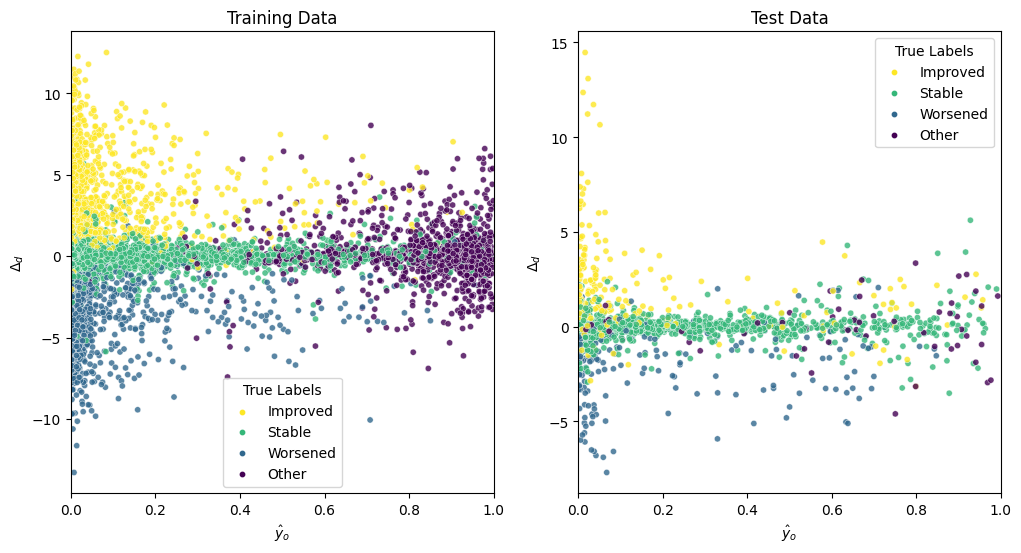

In [53]:
# z_d space for training and test data
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

z_sums = defaultdict(float)
p_os_sums = defaultdict(float)
counts = defaultdict(int)
labels_dict = {}

folds = range(5)

for i in folds:
    labels_train = np.load(directory + f'labels_train_fold_{i+1}.npy')
    z_1ps = np.load(directory + f'z_1ps_train_fold_{i+1}.npy').squeeze()
    z_2ps = np.load(directory + f'z_2ps_train_fold_{i+1}.npy').squeeze()
    z_1os = np.load(directory + f'z_1os_train_fold_{i+1}.npy').squeeze()
    z_2os = np.load(directory + f'z_2os_train_fold_{i+1}.npy').squeeze()
    train_indices = np.load(directory + f'indices_train_fold_{i+1}.npy')

    p_os = 1 - expit(-z_1os) * expit(-z_2os)
    z_diff = z_1ps - z_2ps

    for idx, train_idx in enumerate(train_indices):
        z_sums[train_idx] += z_diff[idx]
        p_os_sums[train_idx] += p_os[idx]
        counts[train_idx] += 1

        if train_idx not in labels_dict:
            labels_dict[train_idx] = labels_train[idx]

z_avg = np.array([z_sums[idx] / counts[idx] for idx in sorted(z_sums.keys())])
p_os_avg = np.array([p_os_sums[idx] / counts[idx] for idx in sorted(p_os_sums.keys())])
labels_avg = np.array([labels_dict[idx] for idx in sorted(labels_dict.keys())])

ax = axs[0]
sns.scatterplot(x=p_os_avg, y=z_avg, hue=labels_avg, palette=paletti, alpha=0.8, s=20, ax = ax)
ax.set_xlabel(r"$\hat{y}_o$")
ax.set_ylabel(r"$\Delta_d$")
ax.set_xlim(0, 1)
ax.set_title("Training Data")

handles = [
    plt.scatter([], [], s=10, color=paletti[0], label='Improved'),
    plt.scatter([], [], s=10, color=paletti[1], label='Stable'),
    plt.scatter([], [], s=10, color=paletti[2], label='Worsened'),
    plt.scatter([], [], s=10, color=paletti[3], label='Other'),
]
ax.legend(handles=handles, title="True Labels")

z_diffs = []
p_oss = []
folds = range(5)
for i in folds:
  labels_test = np.load(directory  + 'labels_test.npy')
  z_1ps = np.load(directory + 'z_1ps_test_fold_' + str(i+1) + '.npy')
  z_2ps = np.load(directory + 'z_2ps_test_fold_' + str(i+1) + '.npy')
  z_1os = np.load(directory + 'z_1os_test_fold_' + str(i+1) + '.npy')
  z_2os = np.load(directory + 'z_2os_test_fold_' + str(i+1) + '.npy')
  p_os = 1 - expit(-z_1os)*expit(-z_2os)
  p_oss.append(p_os)
  z_diff = z_1ps - z_2ps
  z_diffs.append(z_diff)
z = np.mean(z_diffs, axis=0).flatten()
p_os = np.mean(p_oss, axis=0).flatten()
ax = axs[1]
sns.scatterplot(x = p_os, y = z, hue = labels_test, palette = paletti, alpha = 0.8, s = 20, ax = ax)
ax.set_xlabel(r"$\hat{y}_o$")
ax.set_ylabel(r"$\Delta_d$")
ax.set_xlim(0, 1)
ax.set_title("Test Data")
handles = [
    plt.scatter([], [], s = 10, color=paletti[0], label='Improved'),
    plt.scatter([], [], s = 10, color=paletti[1], label='Stable'),
    plt.scatter([], [], s = 10, color=paletti[2], label='Worsened'),
    plt.scatter([], [], s = 10, color=paletti[3], label='Other'),
]
ax.legend(handles=handles, title="True Labels")
plt.show()

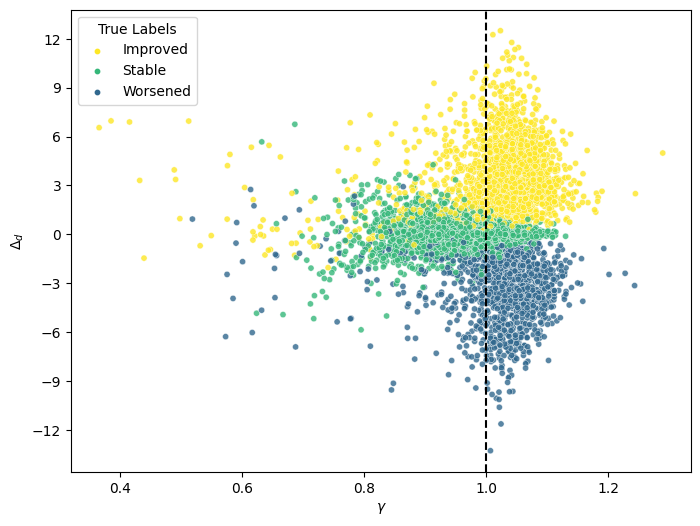

In [54]:
## Gamma against z_diff

z_sums = defaultdict(float)
g_sums = defaultdict(float)
counts = defaultdict(int)
indices_train = defaultdict(list)
labels_dict = {}

for i in folds:
    labels_train = np.load(directory + f'labels_train_fold_{i+1}.npy')
    z_1ps = np.load(directory + f'z_1ps_train_fold_{i+1}.npy').squeeze()
    z_2ps = np.load(directory + f'z_2ps_train_fold_{i+1}.npy').squeeze()
    alphas = np.load(directory + f'alphas_fold_{i+1}.npy').squeeze()
    train_indices = np.load(directory + f'indices_train_fold_{i+1}.npy')
    gammas = 2 ** alphas[train_indices]

    z_diff = z_1ps - z_2ps

    for idx, train_idx in enumerate(train_indices):
        z_sums[train_idx] += z_diff[idx]
        g_sums[train_idx] += gammas[idx]
        counts[train_idx] += 1
        if train_idx not in indices_train:
            indices_train[train_idx] = []

        if train_idx not in labels_dict:
            labels_dict[train_idx] = labels_train[idx]

z_avg = np.array([z_sums[idx] / counts[idx] for idx in sorted(z_sums.keys())])
g_avg = np.array([g_sums[idx] / counts[idx] for idx in sorted(g_sums.keys())])
labels_avg = np.array([labels_dict[idx] for idx in sorted(labels_dict.keys())])
indices_train = np.array([idx for idx in sorted(labels_dict.keys())])
mask = labels_avg != 3

fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(x=g_avg[mask], y=z_avg[mask], hue=labels_avg[mask], palette=paletti[:3], alpha=0.8, s=20, ax = ax)
ax.set_xlabel(r"$\gamma$")
ax.set_ylabel(r"$\Delta_d$")

handles = [
    plt.scatter([], [], s=10, color=paletti[0], label='Improved'),
    plt.scatter([], [], s=10, color=paletti[1], label='Stable'),
    plt.scatter([], [], s=10, color=paletti[2], label='Worsened'),
]
ax.legend(handles=handles, title="True Labels", loc = "upper left")
ax.axvline(1, linestyle = '--', color = 'black')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

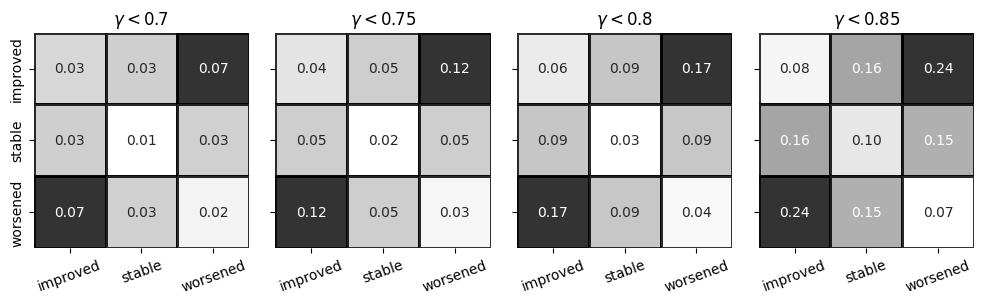

In [55]:
## Quantitative gamma analysis

thresholds = [0.7, 0.75, 0.8, 0.85]

folds = [1, 2, 3, 4, 5]
conf_matrix_all = pd.DataFrame(0.0, index=range(3), columns=range(3))
fig, axes = plt.subplots(1, len(thresholds), figsize=(10, 3), sharex=True, sharey=True)

for threshold in thresholds:
    for i, fold in enumerate(folds):
        labels_train = np.load(directory + f'labels_train_fold_{fold}.npy')
        alphas = np.load(directory + f'alphas_fold_{fold}.npy')
        gammas = 2 ** alphas
        mask = labels_train != 3
        train_indices = np.load(directory + f'indices_train_fold_{fold}.npy')[mask]

        meta_df = pd.read_csv("/gpfs01/berens/data/data/mario_miccai24_challenge/data1/df_task1_train_challenge.csv")
        meta_df = meta_df.loc[train_indices].reset_index(drop=True)
        meta_df["original_index"] = meta_df.index  

        grouped = meta_df.groupby(
            ['id_patient', 'side_eye', 'num_current_visit_at_i', 'num_current_visit_at_i+1', 'delta_t']
        ).agg({'label': list, 'original_index': list}).reset_index()

        pair_indices = defaultdict(list)

        def find_consecutive_original_indices(labels, original_indices):
            """
            Identifies all consecutive label pairs (a, b) and stores their original indices in a symmetric way.
            """
            for i in range(len(labels) - 1):
                pair = tuple(sorted([labels[i], labels[i + 1]]))  
                pair_indices[pair].append(original_indices[i]) 
                pair_indices[pair].append(original_indices[i + 1])

        grouped.apply(lambda row: find_consecutive_original_indices(row['label'], row['original_index']), axis=1)

        gammas = gammas[train_indices] 
        pair_ratios = {} 
        for pair, indices in pair_indices.items():
            indices = np.array(indices)
            if len(indices) > 0:
                ratio = np.sum(gammas[indices] < threshold) / len(indices)
                pair_ratios[pair] = ratio

        unique_labels = sorted(set(meta_df["label"]))

        conf_matrix = pd.DataFrame(0.0, index=unique_labels, columns=unique_labels)

        for (a, b), ratio in pair_ratios.items():
            conf_matrix.loc[a, b] = ratio
            conf_matrix.loc[b, a] = ratio
            
        conf_matrix_all += conf_matrix

    conf_matrix_all /= len(folds)
    ax = axes[thresholds.index(threshold)]
    sns.heatmap(conf_matrix_all, annot=True, cmap="Greys", fmt=".2f", ax=ax, 
                xticklabels=[label_mapping[i] for i in range(len(label_mapping)-1)],
                yticklabels=[label_mapping[i] for i in range(len(label_mapping)-1)],
                cbar=False, square=True, linewidths=1, linecolor='black', annot_kws={"fontsize": 10}, cbar_kws={"shrink": 0.5}, alpha=0.8)
    ax.set_title(r"$\gamma < $" + str(threshold))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
plt.tight_layout()
plt.show()
